# introduction

Objectif : Prédire par Réseaux de neurones une catégorie

Les prescriptions de médicaments comportent parfois des erreurs ou des risques potentiels qui nécessitent une intervention pharmaceutique (IP). Ce projet a pour objectif de développer deux modèles de classification pour prédire la nécessité et la nature de ces IPs, en se basant sur les commentaires de pharmaciens, selon les critères établis par la Société Française de Pharmacie Clinique. Le premier modèle est conçu pour prédire si une IP est classée comme « grave » ou « non-grave ». Le deuxième modèle vise à identifier la classe spécifique de l'IP parmi 11 catégories.

Les données utilisées proviennent des Hôpitaux Universitaires de Strasbourg. Après un prétraitement initial pour supprimer les lignes vides, deux colonnes cibles ont été créées à partir de la colonne 'PLT' : la première (IP_1) codifie la gravité de l'IP (1 pour « grave », 0 pour « non-grave »), tandis que la seconde (IP_2) correspond à la classe d'IP (de 1 à 11).

Pour le modèle de prédiction de gravité (modèle 1), un réseau de neurones séquentiel a été utilisé avec une couche d'embedding, une couche de pooling global, et une couche de sortie sigmoïde. Ce modèle a atteint une précision de 92 %, un score F1 de 0,79, et a bien distingué les interventions graves des non-graves, avec une matrice de confusion montrant une bonne détection des cas graves.  

Pour le modèle de classification des classes d'IP (modèle 2), un réseau de neurones avec une couche LSTM et une activation softmax a été employé. Ce modèle a obtenu une précision globale de 76 %, bien qu’il montre une performance variable selon les classes, avec une précision plus élevée pour les classes majoritaires. La performance de ce modèle est détaillée par classe, avec des scores F1 variant en fonction de la distribution des catégories dans les données.

Ce travail met en lumière un outil potentiel pour assister les pharmaciens dans l'évaluation des IPs, en intégrant des modèles de classification avancés pour une prise de décision éclairée et sécurisée.

# import library

In [ ]:
import pandas as pd
import numpy as np

# DataManagement
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Préparation
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Modèle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM
import tensorflow as tf
from tensorflow.keras import layers, models

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# import files

In [ ]:
!gdown 1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV -O data_defi_2.csv

Downloading...
From: https://drive.google.com/uc?id=1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV
To: /content/data_defi_2.csv
100% 3.08M/3.08M [00:00<00:00, 20.0MB/s]


In [ ]:
!gdown 1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV -O valid_set.csv

Downloading...
From: https://drive.google.com/uc?id=1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV
To: /content/valid_set.csv
100% 556k/556k [00:00<00:00, 6.58MB/s]


In [ ]:
data_defi_2 = pd.read_csv("data_defi_2.csv", sep =";", encoding='latin-1')
valid_set = pd.read_csv("valid_set.csv", sep =";")
display(data_defi_2.head())
display(valid_set.head())

,Column1,Column2,Column3
0,Libellé.Prescription,Avis.Pharmaceutique,PLT
1,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3
2,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1
3,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1
4,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1


,Libellé.Prescription,Avis.Pharmaceutique
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG..."
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin..."


# DataManagement

In [ ]:
#df["Column3"].value_counts()
#df.isnull().sum()
#df.info()

In [ ]:
df = data_defi_2.copy()
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df = df.dropna(subset=['Avis.Pharmaceutique'])
df["text"] = df["Libellé.Prescription"] + " " + df["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df["text"] = df["text"].apply(clean_text)
df['PLT'] = pd.to_numeric(df['PLT'], errors='coerce')
df['IP_1'] = np.where(df['PLT'].isin([4.1, 4.2, 5.1, 5.2, 5.3, 6.3, 6.4]), 1, 0)
df['IP_2'] = np.floor(df['PLT']).astype(int)
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,text,IP_1,IP_2
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3,contramal 100 mgml gouttes buv tramadol 301216...,1,5
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1,imovane 75 mg cpr sécable zopiclone 221216 rec...,1,4
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1,colchicine 1 mg cpr sécable colchicine au vue ...,1,4
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1,pantoprazole 40 mg cpr gastrorésistant eupanto...,1,4
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1,vancomycine 500 mg 1xj posologie infrat veuill...,0,3


# IP_1

## Split train/test

In [ ]:
X = df['text'].values
y = df['IP_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_dense, y_train)

print(f"Avant SMOTE : {sum(y_train==1)}/{len(y_train)} positifs")
print(f"Après SMOTE  : {sum(y_train_res==1)}/{len(y_train_res)} positifs")

Avant SMOTE : 3622/18512 positifs
Après SMOTE  : 14890/29780 positifs


## Modèle

In [ ]:
model_IP_1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model_IP_1.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model_IP_1.fit(X_train_dense, y_train,
                    validation_split=0.1,
                    epochs=4,
                    batch_size=32)

Epoch 1/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8462 - loss: 0.3643 - val_accuracy: 0.9098 - val_loss: 0.2247
Epoch 2/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9414 - loss: 0.1472 - val_accuracy: 0.9087 - val_loss: 0.2246
Epoch 3/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.9641 - loss: 0.0915 - val_accuracy: 0.9077 - val_loss: 0.2750
Epoch 4/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.9818 - loss: 0.0508 - val_accuracy: 0.9006 - val_loss: 0.3112
Epoch 5/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9884 - loss: 0.0325 - val_accuracy: 0.9023 - val_loss: 0.3549


## evaluation

In [ ]:
y_pred_proba = model_IP_1.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred):.3f}")
print(f"Recall : {recall_score(y_test, y_pred):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred):.3f}")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy : 0.908
Precision : 0.748
Recall : 0.801
F1 score : 0.774
Matrice de confusion :
[[3479  244]
 [ 180  726]]
Classification report :
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3723
           1       0.75      0.80      0.77       906

    accuracy                           0.91      4629
   macro avg       0.85      0.87      0.86      4629
weighted avg       0.91      0.91      0.91      4629



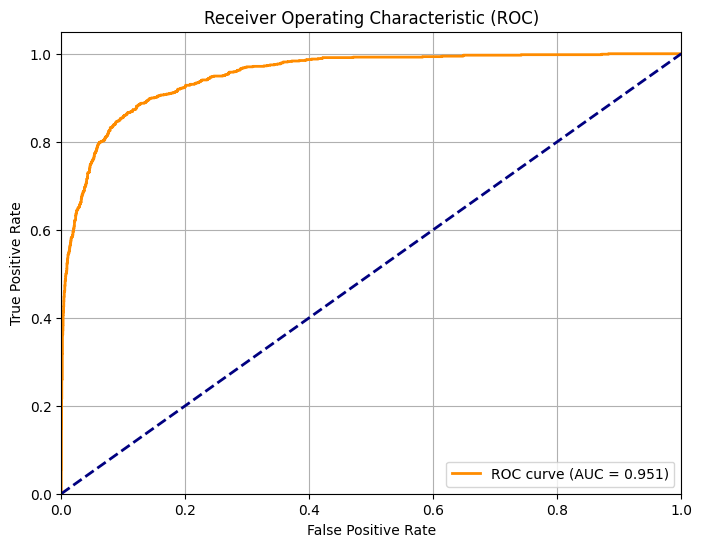

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# IP_2

## Split train/test

In [ ]:
X = df_prepared['text'].values
y = df_prepared['IP_2'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

## Modèle

In [ ]:
num_classes = 12

model_IP_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # sortie multiclasse
])

model_IP_2.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model_IP_2.fit(X_train_dense, y_train,
                    validation_split=0.1,
                    epochs=4,
                    batch_size=32)

Epoch 1/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.5735 - loss: 1.4270 - val_accuracy: 0.7468 - val_loss: 0.7931
Epoch 2/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.8320 - loss: 0.5380 - val_accuracy: 0.7640 - val_loss: 0.7767
Epoch 3/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9095 - loss: 0.2992 - val_accuracy: 0.7565 - val_loss: 0.8558
Epoch 4/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9409 - loss: 0.1951 - val_accuracy: 0.7527 - val_loss: 0.9461
Epoch 5/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9594 - loss: 0.1371 - val_accuracy: 0.7424 - val_loss: 1.0113


## evaluation

In [ ]:
y_pred_proba = model_IP_2.predict(X_test_dense)
y_pred = y_pred_proba.argmax(axis=1)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred, average='macro'):.3f}")
print(f"Recall : {recall_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy : 0.774
Precision : 0.563
Recall : 0.540
F1 score : 0.550
Classification report :
              precision    recall  f1-score   support

           1       0.88      0.88      0.88      2253
           2       0.81      0.73      0.77       151
           3       0.45      0.38      0.41       194
           4       0.73      0.75      0.74       613
           5       0.63      0.54      0.58       166
           6       0.81      0.83      0.82       193
           7       0.00      0.00      0.00         2
           8       0.69      0.79      0.74       589
           9       0.00      0.00      0.00         4
          10       0.68      0.55      0.61       148
          11       0.51      0.50      0.50       316

    accuracy                           0.77      4629
   macro avg       0.56      0.54      0.55      4629
weighted avg       0.77      0.77      0.77      4629



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# Test

In [ ]:
df_test = valid_set.copy()
df_test["text"] = df_test["Libellé.Prescription"] + df["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df_test["text"] = df_test["text"].apply(clean_text)
df_test.head()

,Libellé.Prescription,Avis.Pharmaceutique,text
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...,perf nefopam 60 mg acupan 125 droperidol drol...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...,lamaline gélule221216 recommandé imovane 375m...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG...",xyzall 5 mg cprau vue de la dfg il est recomma...
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...,amoxicilline aclavulanique 1g x4j augmentindo...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin...",felodipine lp 5 mg sandoz cpr à libération pro...


In [ ]:
X_train = df_test["text"]

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()

# Modèle

y_pred_1 = model_IP_1.predict(X_train_dense)
y_pred_1 = (y_pred_1 > 0.5).astype("int32").flatten()

y_pred_2 = model_IP_2.predict(X_train_dense)
y_pred_2 = np.argmax(y_pred_2, axis=1)

### Résultat

y_pred_1 = pd.Series(y_pred_1, name="Statue")
y_pred_2 = pd.Series(y_pred_2, name="Classe")
result = pd.concat([df_test, y_pred_1, y_pred_2], axis=1)

result.head()

KeyError: 'Libellé.Prescription'

In [ ]:
display(result.groupby('Statue').size())
display(result.groupby('Classe').size())

,0
Statue,
0,16768
1,1744


,0
Classe,
1,8977
2,603
3,772
4,2454
5,656
6,786
8,2438
10,562
11,1264
